# 🌟 **Mô hình Transformer trong bài toán dịch máy** 🌟  
### 📚 **Đồ án môn học:** Trí tuệ nhân tạo cơ bản
## 📝 **Thông tin nhóm**  
<style>
  table {
    width: 100%;
    border-collapse: collapse;
    font-size: 16px; /* Tăng kích thước chữ */
  }
  th, td {
    border: 1px solid #ddd;
    padding: 10px;
    text-align: left;
  }
  th {
    background-color: #f2f2f2;
  }
</style>
<div>  
<table style="width:100%; font-size: 18px; border-collapse: collapse; text-align: left;">  
  <tr style="border-bottom: 1px solid #ddd;">  
    <th style="padding: 8px;">Họ và Tên</th>  
    <th style="padding: 8px;">MSSV</th>  
  </tr>  
  <tr>  
    <td style="padding: 8px;">Trần Nguyên Bình</td>  
    <td style="padding: 8px;">21E1010005</td>  
  </tr>
  <tr>  
    <td style="padding: 8px;">Phạm Thị Lê Na</td>  
    <td style="padding: 8px;">21E1010002</td>  
  </tr>  
  <tr>  
    <td style="padding: 8px;">Lê Bá Quốc Trung</td>  
    <td style="padding: 8px;">21E1020020</td>  
  </tr>  
</table>  
</div>  

---
## 💡 **Giới thiệu**   
**Transformer** là một kiến trúc mạnh mẽ trong lĩnh vực xử lý ngôn ngữ tự nhiên, được thiết kế đặc biệt cho các bài toán dịch máy. Với khả năng xử lý song song và sử dụng cơ chế attention, Transformer mang lại hiệu quả cao trong việc dịch tự động giữa các ngôn ngữ khác nhau.

Trong đồ án này, Transformer sẽ được áp dụng để dịch từ tiếng Anh sang tiếng Việt. Hệ thống sẽ dựa trên tập dữ liệu song ngữ đã được xử lý và gán nhãn, sử dụng thư viện PyTorch để xây dựng và huấn luyện mô hình.

---
## 🎯 **Mục tiêu:**
1. Chuẩn bị và tiền xử lý dữ liệu ngôn ngữ song ngữ.  
2. Nghiên cứu và triển khai kiến trúc Transformer bằng PyTorch.  
3. Huấn luyện, tinh chỉnh mô hình và đánh giá hiệu suất trên tập dữ liệu dịch máy.
---

### **1\. Thiết lập môi trường**

#### **1\.1 Cài đặt thư viện cần thiết**

In [ ]:
!pip install underthesea -q

#### **1\.2 Import các thư viện cần thiết**

In [ ]:
import pandas as pd
import numpy as np
import re,string
from underthesea import word_tokenize
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from gensim.models import KeyedVectors
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from timeit import default_timer as timer
import math
import warnings
warnings.filterwarnings('ignore')

#### **1\.3 Đọc và kiểm tra dữ liệu**

Tập dữ liệu English Vietnamese Translation: https://www.kaggle.com/datasets/hungnm/englishvietnamese-translation?select=en_sents

Mô tả: Dữ liệu bao gồm hai tệp văn bản: một tệp chứa các câu tiếng Anh và một tệp chứa các bản dịch tiếng Việt tương ứng. Cụ thể, mỗi dòng trong tệp đầu tiên là một câu tiếng Anh, và dòng tương ứng ở tệp thứ hai là bản dịch tiếng Việt của câu đó. Bộ dữ liệu cung cấp các cặp câu song ngữ song song, đảm bảo tính toàn vẹn và sự phù hợp cho việc huấn luyện mô hình dịch máy. Các câu trong tập dữ liệu có độ dài và ngữ cảnh đa dạng, tạo điều kiện cho mô hình học được các đặc trưng quan trọng trong bài toán dịch ngôn ngữ.


In [ ]:
# Đọc và kiểm tra dữ liệu
data_dir = "../input/englishvietnamese-translation/"
en_sents = open(data_dir + 'en_sents', "r").read().splitlines()
vi_sents = open(data_dir + 'vi_sents', "r").read().splitlines()
raw_data = {
        "en": [line for line in en_sents[:170000]], # Only take first 170000 lines
        "vi": [line for line in vi_sents[:170000]],
    }
df = pd.DataFrame(raw_data, columns=["en", "vi"])
print(len(en_sents))
df.head()

254090


,en,vi
0,Please put the dustpan in the broom closet,xin vui lòng đặt người quét rác trong tủ chổi
1,Be quiet for a moment.,im lặng một lát
2,Read this,đọc này
3,Tom persuaded the store manager to give him ba...,tom thuyết phục người quản lý cửa hàng trả lại...
4,Friendship consists of mutual understanding,tình bạn bao gồm sự hiểu biết lẫn nhau


**Nhận xét:** Tập dữ lệu gồm 254090 nhóm, một nhóm gồm một câu tiếng anh và bản dịch tiếng Việt do con người thực hiện. Nhóm nghiên cứu sẽ tiến hành dùng 170000 nhóm dữ liệu trên cho mục tiêu huấn luyện và kiểm tra.

## **2\. Tiền xử lý dữ liệu**

#### **2\.1 Kiểm tra các giá trị NaN**

In [ ]:
df.isna().sum()

en    0
vi    0
dtype: int64

#### **2\.2 Tạo hàm chuẩn hóa văn bản**

Bao gồm:
- Xóa dấu câu
- Chuyển thành chữ thường
- Chuẩn hóa khoảng trắng

In [ ]:
def preprocessing(df):
  df["en"] = df["en"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) # Remove punctuation
  df["vi"] = df["vi"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation)))
  df["en"] = df["en"].apply(lambda ele: ele.lower()) # convert text to lowercase
  df["vi"] = df["vi"].apply(lambda ele: ele.lower())
  df["en"] = df["en"].apply(lambda ele: ele.strip())
  df["vi"] = df["vi"].apply(lambda ele: ele.strip())
  df["en"] = df["en"].apply(lambda ele: re.sub("\s+", " ", ele))
  df["vi"] = df["vi"].apply(lambda ele: re.sub("\s+", " ", ele))

  return df

df = preprocessing(df)
df.head()

,en,vi
0,please put the dustpan in the broom closet,xin vui lòng đặt người quét rác trong tủ chổi
1,be quiet for a moment,im lặng một lát
2,read this,đọc này
3,tom persuaded the store manager to give him ba...,tom thuyết phục người quản lý cửa hàng trả lại...
4,friendship consists of mutual understanding,tình bạn bao gồm sự hiểu biết lẫn nhau


#### **2\.3 Khởi tạo tokenizer và từ điển cho tiếng Anh và tiếng Việt**


In [ ]:
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'vi'

token_transform = {}
vocab_transform = {}

def vi_tokenizer(sentence):
    tokens = word_tokenize(sentence)
    return tokens

token_transform[SRC_LANGUAGE] = get_tokenizer('basic_english')
token_transform[TGT_LANGUAGE] = get_tokenizer(vi_tokenizer)

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    for index,data_sample in data_iter:
        yield token_transform[language](data_sample[language])

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    train_iter = df.iterrows()
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

## **3\. Xây dựng mô hình**

#### **3\.1 Thiết lập mô hình Transformer**

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

#### **3\.2 Tạo mask cho decoder trong Transformer**

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

#### **3\.3 Khai báo mô hình**

In [ ]:
# Khai báo mô hình
torch.manual_seed(0)
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DROP_OUT = 0.1

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM,DROP_OUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

#### **3\.4 Khai báo hàm mất mát và thuật toán tối ưu**

In [ ]:

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

#### **3\.5 Một vài hàm tiện ích**

In [ ]:
# Một vài hàm tiện ích
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln],
                                               vocab_transform[ln],
                                               tensor_transform)

def collate_fn(batch):
    src_batch, tgt_batch = [], []

    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

## **4\. Huấn luyện mô hình**

#### **4\.1 Phân chia tập huấn luyện và tập kiểm tra**

In [ ]:
split_ratio = 0.9
split = round(df.shape[0]* split_ratio)
train = df.iloc[:split]
train_ds = list(zip(train['en'],train['vi']))
valid = df.iloc[split:]
val_ds = list(zip(valid['en'],valid['vi']))

#### **4\.2 Định nghĩa hàm huấn luyện và hàm đánh giá**

In [ ]:
from torch.utils.data import DataLoader

accumulation_steps = 5

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    val_los = 0
    train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    optimizer.zero_grad()
    for i, (src, tgt) in enumerate(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps # Normalize our loss (if averaged)
        loss.backward()

        if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
            optimizer.step() # Now we can do an optimizer step
            optimizer.zero_grad() # Reset gradients tensor

        losses += loss.item()

    return losses / len(train_dataloader)

def evaluate(model):
    model.eval()
    losses = 0

    #val_iter = valid.iterrows()
    val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps # Normalize our loss (if averaged)
        losses += loss.item()

    return losses / len(val_dataloader)

#### **4\.3 Định nghĩa phương pháp Early Stopping**

In [ ]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

#### **4\.4 Tiến hành huấn luyện**

In [ ]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)
NUM_EPOCHS = 30
history = {
        "loss": [],
        "val_los": []
        }

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    history['loss'].append(train_loss)
    history['val_los'].append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    # Early Stopping
    early_stopping(train_loss, val_loss)
    if early_stopping.early_stop:
        print("We are at epoch:", epoch)
        break

Epoch: 1, Train loss: 0.944, Val loss: 0.629, Epoch time = 179.434s
Epoch: 2, Train loss: 0.540, Val loss: 0.407, Epoch time = 178.743s
Epoch: 3, Train loss: 0.382, Val loss: 0.312, Epoch time = 178.537s
Epoch: 4, Train loss: 0.300, Val loss: 0.263, Epoch time = 178.240s
Epoch: 5, Train loss: 0.248, Val loss: 0.232, Epoch time = 178.487s
Epoch: 6, Train loss: 0.213, Val loss: 0.210, Epoch time = 178.195s
Epoch: 7, Train loss: 0.187, Val loss: 0.193, Epoch time = 178.430s
Epoch: 8, Train loss: 0.166, Val loss: 0.181, Epoch time = 178.154s
Epoch: 9, Train loss: 0.150, Val loss: 0.172, Epoch time = 181.787s
Epoch: 10, Train loss: 0.136, Val loss: 0.168, Epoch time = 183.812s
Epoch: 11, Train loss: 0.124, Val loss: 0.162, Epoch time = 179.327s
Epoch: 12, Train loss: 0.115, Val loss: 0.157, Epoch time = 178.521s
Epoch: 13, Train loss: 0.106, Val loss: 0.154, Epoch time = 178.551s
Epoch: 14, Train loss: 0.098, Val loss: 0.153, Epoch time = 177.628s
Epoch: 15, Train loss: 0.091, Val loss: 0.1

#### **4\.5 Trực quan hóa kết quả huấn luyện**

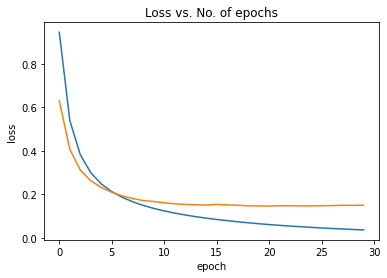

In [ ]:
# Vẽ biểu đồ huấn luyện
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history['loss'], label = "loss")
plt.plot(history['val_los'], label = "Val loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

#### **4\.6 Lưu mô hình**

In [ ]:
torch.save(transformer.state_dict(), "viEn_transformer.pth")

## **5. Ứng dụng mô hình**

#### **5\.1 Định nghĩa các hàm dùng để lấy được từ trong tập từ vựng**

In [ ]:

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

#### **5\.2 Kiểm tra kết quả dịch thuật**

In [ ]:
# Kiểm tra dịch thuật
from random import randint
rand = [randint(170000,200000) for i in range(10)]
test_set = [
        [en_sents[i] for i in rand],
        [vi_sents[i] for i in rand]]

for i in range(len(test_set[0])):
    print('Input English sentence:', test_set[0][i])
    print('Actual Vietnamese Translation:', test_set[1][i])
    print('Predicted Vietnamese Translation:', translate(transformer, test_set[0][i]))
    print("\n")

Input English sentence: Tears ran down my face.
Actual Vietnamese Translation: Nước mắt chảy dài trên khuôn mặt tôi.
Predicted Vietnamese Translation:  nước mắt chảy xuống mặt tôi làm bạn thất vọng 


Input English sentence: I'm in the toilet
Actual Vietnamese Translation: tôi đang ở trong nhà vệ sinh
Predicted Vietnamese Translation:  tôi đã làm gì nếu dẫn đường vệ sinh 


Input English sentence: Stop playing hard to get.
Actual Vietnamese Translation: ngừng chơi hết mình để có được.
Predicted Vietnamese Translation:  ngừng chơi hết mình để bắt được sự cố tình 


Input English sentence: It's clear that it's so
Actual Vietnamese Translation: rõ ràng là như vậy
Predicted Vietnamese Translation:  nó được bao xa cách làm điều đó một cách giả vờ như vậy 


Input English sentence: I'll have to give this some thought.
Actual Vietnamese Translation: tôi sẽ phải suy nghĩ điều này
Predicted Vietnamese Translation:  tôi đã làm gì khi không được trả một số điều này có tội cứu 


Input English sen

## **6. Đánh giá mô hình**

#### **6\.1 Load lại mô hình đã tải**

In [ ]:
torch.manual_seed(0)
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DROP_OUT = 0.1


loaded_transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM,DROP_OUT)
loaded_transformer.load_state_dict(torch.load("/kaggle/input/model-vie/viEn_transformer.pth", map_location=DEVICE))
loaded_transformer = loaded_transformer.to(DEVICE)

#### **6\.2  Cài đặt các thư viện đánh giá mô hình**

In [ ]:
!pip install rouge -q
!pip install nltk -q

#### **6.3 Định nghĩa các độ đo đánh giá mô hình**

In [ ]:
import torch
import torch.nn.functional as F
import math
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge

def calculate_perplexity(model, dataloader, max_len=100):
    model.eval()
    total_loss = 0
    total_tokens = 0
    with torch.no_grad():
        for src, tgt in dataloader:
            src = src.to(DEVICE)
            tgt = tgt.to(DEVICE)
            tgt_input = tgt[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
            tgt_out = tgt[1:, :]
            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1), ignore_index=PAD_IDX, reduction='sum')
            total_loss += loss.item()
            total_tokens += (tgt_out != PAD_IDX).sum().item()

    if total_tokens == 0:
        return float('inf')
    return math.exp(total_loss / total_tokens)


def calculate_bleu(model, test_data, max_len=100):
    references = []
    hypotheses = []
    for src, tgt in test_data:
        reference = [token_transform[TGT_LANGUAGE](tgt)]
        hypothesis = token_transform[TGT_LANGUAGE](translate(model, src))
        references.append(reference)
        hypotheses.append(hypothesis)
    return corpus_bleu(references, hypotheses)

#### **6\.4 Tiến hành đánh giá**

In [ ]:
from torch.utils.data import DataLoader
val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

perplexity = calculate_perplexity(loaded_transformer, val_dataloader)
print(f'Perplexity: {perplexity}')

bleu_score = calculate_bleu(loaded_transformer, val_ds)
print(f'BLEU: {bleu_score}')

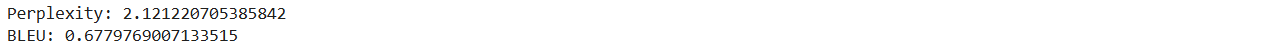

**Nhận xét:**
- Mô hình Transformer đạt BLEU = 0.6779. Đây là kết quả khá tốt, phản ánh khả năng dịch chính xác với các bản dịch tham chiếu, đặc biệt khi dịch giữa hai ngôn ngữ có cấu trúc ngữ pháp khác biệt như tiếng Anh và tiếng Việt. Mô hình thể hiện khả năng học các mối quan hệ ngữ nghĩa và ngữ pháp cơ bản, đồng thời duy trì được sự tự nhiên của câu dịch trong phần lớn trường hợp.
- Perplexity = 2.1212 cho thấy mô hình có độ không chắc chắn thấp khi dự đoán từ tiếp theo, chỉ với khoảng 2.12 khả năng. Điều này cho thấy mô hình có khả năng dự đoán chính xác từ tiếp theo trong chuỗi, đồng thời phản ánh hiệu quả trong việc học các đặc trưng ngữ nghĩa và ngữ pháp của ngôn ngữ. Mức perplexity này cho thấy mô hình có thể hiểu được mối quan hệ giữa các từ trong câu và đưa ra dự đoán chính xác về chuỗi từ.
